In [ ]:
import urx
import time
import pyfirmata
import numpy as np
import pyrealsense2 as rs
import cv2
import os

In [ ]:
def get_ar_loc(color_image, depth_frame, aruco, dictionary, color_intrinsics):
    
    gray_image = cv2.cvtColor(color_image, cv2.COLOR_RGB2BGR)
    corners, ids, rejectedImgPoints = aruco.detectMarkers(gray_image, dictionary)

    if len(corners)!=0:
        point = np.average(corners[0][0], axis=0)
        depth = depth_frame.get_distance(point[0], point[1])
        point = np.append(point,depth)
        if depth!=0:
            x=point[0]
            y=point[1]
            z=point[2]
            x,y,z=rs.rs2_deproject_pixel_to_point(color_intrinsics, [x, y], z)
            # print([x,y,z])
            
        k = np.array([[623.47,0,311.039],[0,623.47,235.941],[0,0,1]])
        d = np.zeros(5)
        rvec, tvec, markerPoints = aruco.estimatePoseSingleMarkers(corners[0],0.084,k,d)
        cv2.drawFrameAxes(color_image, k, d, rvec, tvec, 0.03)
        flag = 1
    else:
        x=y=z=0
        flag = 0

    aruco.drawDetectedMarkers(color_image, corners, ids, (0,255,0))
    
    return np.array([x,y,z]), corners, flag

def get_pc(depth_frame, pc):
    
    # depth_frame = decimate.process(depth_frame)

    # Grab new intrinsics (may be changed by decimation)
    depth_intrinsics = rs.video_stream_profile(
        depth_frame.profile).get_intrinsics()
    w, h = depth_intrinsics.width, depth_intrinsics.height

    points = pc.calculate(depth_frame)

    # Pointcloud data to arrays
    v = points.get_vertices()
    verts = np.asanyarray(v).view(np.float32).reshape(h, w, 3)  # xyz
    
    return verts

def get_observation(impath,arraypath):
    # Initialize aruco for the ar tag
    aruco = cv2.aruco
    dictionary = aruco.getPredefinedDictionary(aruco.DICT_4X4_50)

    # Processing blocks
    pc = rs.pointcloud()
    decimate = rs.decimation_filter()
    decimate.set_option(rs.option.filter_magnitude, 2 ** 1)

    # Configure depth and color streams
    pipeline = rs.pipeline()
    config = rs.config()

    # Get device product line for setting a supporting resolution
    pipeline_wrapper = rs.pipeline_wrapper(pipeline)
    pipeline_profile = config.resolve(pipeline_wrapper)
    device = pipeline_profile.get_device()
    device_product_line = str(device.get_info(rs.camera_info.product_line))

    found_rgb = False
    for s in device.sensors:
        if s.get_info(rs.camera_info.name) == 'RGB Camera':
            found_rgb = True
            break
    if not found_rgb:
        print("The demo requires Depth camera with Color sensor")
        exit(0)

    config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 30)

    if device_product_line == 'L500':
        config.enable_stream(rs.stream.color, 960, 540, rs.format.bgr8, 30)
    else:
        config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)

    # Start streaming
    pipeline.start(config)

    colorizer = rs.colorizer()
    colorizer.set_option(rs.option.visual_preset, 1) # 0=Dynamic, 1=Fixed, 2=Near, 3=Far
    colorizer.set_option(rs.option.min_distance, 0.35)
    colorizer.set_option(rs.option.max_distance, 1)

    try:
        while True:

            # Wait for a coherent pair of frames: depth and color
            frames = pipeline.wait_for_frames()
            depth_frame = frames.get_depth_frame()
            color_frame = frames.get_color_frame()
            color_intrinsics = color_frame.profile.as_video_stream_profile().intrinsics
            if not depth_frame or not color_frame:
                continue

            # Convert images to numpy arrays
            depth_image = np.asanyarray(depth_frame.get_data())
            # depth_image = np.asanyarray(colorizer.colorize(depth_frame).get_data())
            color_image = np.asanyarray(color_frame.get_data())

            # Find where the ar tag is
            reference, corners, flag = get_ar_loc(color_image, depth_frame, aruco, dictionary, color_intrinsics)

            # Apply colormap on depth image (image must be converted to 8-bit per pixel first)
            depth_image = np.asanyarray(colorizer.colorize(depth_frame).get_data())
            depth_colormap = cv2.applyColorMap(cv2.convertScaleAbs(depth_image, alpha=1), cv2.COLORMAP_JET)

            depth_colormap_dim = depth_colormap.shape
            color_colormap_dim = color_image.shape

            # If depth and color resolutions are different, resize color image to match depth image for display
            if depth_colormap_dim != color_colormap_dim:
                resized_color_image = cv2.resize(color_image, dsize=(depth_colormap_dim[1], depth_colormap_dim[0]), interpolation=cv2.INTER_AREA)
                images = np.hstack((resized_color_image, depth_colormap))
            else:
                images = np.hstack((color_image, depth_colormap))

            # Show images
            # cv2.namedWindow('RealSense', cv2.WINDOW_AUTOSIZE)
            # cv2.imshow('RealSense', images)
            cv2.imwrite(impath,images)

            # Get the point cloud
            verts = get_pc(depth_frame, pc)
            k = np.array([[623.47,0,311.039],[0,623.47,235.941],[0,0,1]])
            d = np.zeros(5)
            rvec, tvec, markerPoints = aruco.estimatePoseSingleMarkers(corners[0],0.084,k,d)
            R,_ = cv2.Rodrigues(rvec)
            temp = verts.reshape(-1,3)
            transformed = np.matmul(R.T,temp.T-tvec[0].T)
            transformed = transformed.T.reshape(480,640,3)
            transformed[:,:,2] = np.where(transformed[:,:,2]<0.06,transformed[:,:,2],0)
            np.save(arraypath,transformed)

            if flag == 1:
                break

    finally:

        # Stop streaming
        # cv2.destroyAllWindows()
        cv2.waitKey(1)
        pipeline.stop()
        

In [ ]:
class gripperclass:
    def __init__(self, port, pinlist):
        # port: string for port name
        # pinlist: list of string for pin names
        self.ctr = pyfirmata.Arduino(port)
        self.pins = []
        for i in range(4):
            self.pins.append(self.ctr.get_pin(pinlist[i]))
        
        # initialize all voltage controls to 0, range 0-10V
        # v: [left_out, left_in, right_in, right_out]
        self.v = np.zeros(4)
        
        self.out_index = [0,3]
        self.in_index = [1,2]
    
    def setv(self,v,mode='absolute'):
        # is the pressure relative or absolute?
        if mode == 'relative':
            v = self.getv() + v
        elif mode == 'absolute':
            v = v
        
        self.v = v
        
        # Send the pwd signals to all pins
        v = self.vtopwd(v)
        
        print("setv", v)
        
        for i in range(4):
            self.pins[i].write(v[i])
        
        time.sleep(0.1)
    
    def close_grip(self,v,mode='absolute'):
        # v is just one voltage number here, for the 2 out chambers
        # apply pressure symmetrically to close the gripper
        if mode == 'relative':
            temp = np.zeros(4)
            
        elif mode == 'absolute':
            temp = self.getv()
        
        temp[self.out_index] = v
        self.setv(temp,mode)
        
    def open_grip(self,v,mode='absolute'):
        # v is just one voltage number here, for the 2 inner chambers
        # apply pressure symmetrically to close the gripper
        if mode == 'relative':
            temp = np.zeros(4)
            
        elif mode == 'absolute':
            temp = self.getv()
        
        print("open",v)
        print("temp",temp)
        
        temp[self.in_index] = v
        self.setv(temp,mode) 
    
    def vtopwd(self,v):
        # min voltage 0, max voltage 10
        v = np.clip(v,0,5)
        
        # scale to 0-1 for python pwd control
        return v/10
    
    def getv(self):
        return self.v
    
    def reset(self):
        self.v = np.zeros(4)
        self.setv(self.v)

class pneurobot:
    def __init__(self, port, pinlist, ip):
        # port: string for port name
        # pinlist: list of string for pin names
        # ip: ip address for the robot
        
        # initialize the robot arm, payload coordinate, acceleration, velocity
        self.arm = urx.Robot(ip)
        self.arm.set_tcp((0,0,0.1,0,0,0))
        self.arm.set_payload(0.31,(0,0,0.1))
        time.sleep(0.5)
        self.a = 0.04;self.v = 0.04;self.v_fast=0.06
        
        # initialize arduino for pneumatic gripper
        self.gripper = gripperclass(port,pinlist)
        
        # Initial arm pose, using end coordinate
        self.arm_pose = [0.7559,0.18,0.20,2.2141,2.2222,0]
        
        # Initial voltage to arduino, all 0s
        self.voltage = np.zeros(4)
        
        # Force reset when initializing
        self.reset_all()
    
    def movel(self, pose, relative=False):
        if relative==False and 0.5<=pose[0]<=0.8 and -0.2<=pose[1]<=0.2 and 0<=pose[2]<=0.2:
            self.arm.movel(pose, self.a, self.v, relative=relative)
            self.arm_pose = self.arm.getl()
        else:
            print("location out of bounding box")
    
    def getl(self):
        return self.arm.getl(wait=False, _log=False)
    
    def get_joints(self):
        return self.arm.getj(wait=False)
    
    def rotate_end(self, joints):       
        self.arm.movej(joints, acc=self.a, vel=self.v_fast, wait=False, relative=False, threshold=None)
                
    def reset_arm(self):
        self.arm.movel(self.arm_pose, self.a, self.v_fast, relative=False)
        
    def reset_gripper(self):
        self.gripper.reset()
        self.voltage = self.gripper.getv()
        
    def reset_all(self):
        self.reset_arm()
        self.reset_gripper()
        
    def close(self):
        # close the connection to urx robot
        self.arm.close()

# data collection

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
port = '/dev/cu.usbmodem14601'
pinlist = ['d:3:p','d:5:p','d:6:p','d:10:p']
ip = "192.168.0.246"

myrob = pneurobot(port, pinlist, ip)

tried 11 times to find a packet in data, advertised packet size: -2, type: 3
Data length: 68
tried 11 times to find a packet in data, advertised packet size: -2, type: 3
Data length: 1092
tried 11 times to find a packet in data, advertised packet size: -2, type: 3
Data length: 1454


setv [0. 0. 0. 0.]


In [ ]:
myrob.reset_arm()

In [ ]:
myrob.movel([0.7559,0.18,0.20,2.2141,2.2222,0],relative=False)

Exception in thread Thread-36:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/amazon_robotic/lib/python3.9/threading.py", line 980, in _bootstrap_inner
    self.run()
  File "/Users/labgu/amazon/urx/ursecmon.py", line 293, in run
    data = self._get_data()
  File "/Users/labgu/amazon/urx/ursecmon.py", line 340, in _get_data
    tmp = self._s_secondary.recv(1024)
ConnectionResetError: [Errno 54] Connection reset by peer


### get initial image

In [ ]:
file_name="/Users/labgu/amazon/observations-cube/"+"trajectory-"+time.strftime('%Y-%b-%d-%H-%M-%S-%Z')
print(file_name)

get_observation(file_name+'.png',file_name+'.npy')

/Users/labgu/amazon/observations-cube/trajectory-2022-Oct-21-14-44-28-PDT


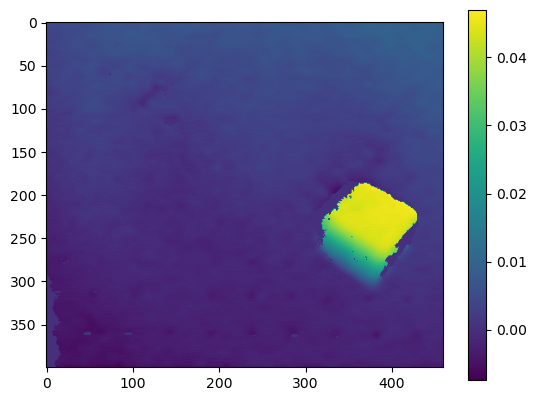

In [ ]:
import matplotlib.pyplot as plt
transformed = np.load(file_name+".npy")
z = transformed[80:,100:560,2]
c = plt.imshow(z)
plt.colorbar(c)

### move  robot arm

In [ ]:
position_above=[0.766,-0.038,0.07,2.2141,2.2222,0]

myrob.movel(position_above,relative=False)


### rotate last joint

In [ ]:
current_joints=myrob.get_joints()
print(current_joints)
new_joints=current_joints.copy()
new_joints[-1]=new_joints[-1]+0.15
print(new_joints)
myrob.rotate_end(new_joints)

[2.9172587394714355, -0.7576053899577637, 1.2476967016803187, -2.0642601452269496, -1.567934815083639, -2.7657097021686]
[2.9172587394714355, -0.7576053899577637, 1.2476967016803187, -2.0642601452269496, -1.567934815083639, -2.6157097021686]


In [ ]:
current_joints=myrob.get_joints()
print(current_joints)
new_joints=current_joints.copy()
new_joints[-1]=new_joints[-1]-0.05
print(new_joints)
myrob.rotate_end(new_joints)

[2.9172348976135254, -0.7576173108867188, 1.2476967016803187, -2.0642124615111292, -1.5679829756366175, -4.1157055536853235]
[2.9172348976135254, -0.7576173108867188, 1.2476967016803187, -2.0642124615111292, -1.5679829756366175, -4.165705553685323]


#### going downward

In [ ]:
import copy

position_above=myrob.getl()
print(position_above)

position_below=copy.deepcopy(position_above)

position_below[2]=0.025
print(position_below)
myrob.movel(position_below,relative=False)

[0.7660148933395192, -0.03797474131378809, 0.07005531532211674, 1.173960275622745, 2.909327246534268, -0.0028636348414410296]
[0.7660148933395192, -0.03797474131378809, 0.025, 1.173960275622745, 2.909327246534268, -0.0028636348414410296]


### grasp and lift

In [ ]:
port = '/dev/cu.usbmodem14601'
pinlist = ['d:3:p','d:5:p','d:6:p','d:10:p']
pressure_control=gripperclass(port, pinlist)
v_input=1.8
pressure_control.close_grip(v=v_input,mode='absolute')


setv [0.18 0.   0.   0.18]


In [ ]:
myrob.movel(position_above,relative=False)

In [ ]:
offset=[0,0,0.001,0,0,0]
myrob.movel([position_below[i]+offset[i] for i in range(6)],relative=False)

In [ ]:
port = '/dev/cu.usbmodem14601'
pinlist = ['d:3:p','d:5:p','d:6:p','d:10:p']
pressure_control=gripperclass(port, pinlist)
pressure_control.open_grip(v=0,mode='absolute')

open 0
temp [0. 0. 0. 0.]
setv [0. 0. 0. 0.]


In [ ]:
myrob.movel(position_above,relative=False)

### success, save, and file rename

In [ ]:
import json
 
dictionary = {
    "position_above": position_above,
    "position_below": position_below,
    "voltage": v_input}
 
with open(file_name+".json", "w") as outfile:
    json.dump(dictionary, outfile)

In [ ]:
myrob.close()

Exception in thread Exception in thread Exception in thread Exception in thread Exception in thread Thread-31:
Traceback (most recent call last):
Thread-29:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/amazon_robotic/lib/python3.9/threading.py", line 980, in _bootstrap_inner
Thread-26:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/amazon_robotic/lib/python3.9/threading.py", line 980, in _bootstrap_inner
Exception in thread Thread-33:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/amazon_robotic/lib/python3.9/threading.py", line 980, in _bootstrap_inner
Thread-32:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/amazon_robotic/lib/python3.9/threading.py", line 980, in _bootstrap_inner
Thread-25Exception in thread Exception in thread :
Traceback (most recent call last):
  File "/opt/anaconda3/envs/amazon_robotic/lib/python3.9/threading.py", line 980, in _bootstrap_inner
  File "/opt/anaconda3/envs/amazon_robotic/lib/python3

In [ ]:
port = '/dev/cu.usbmodem14601'
pinlist = ['d:3:p','d:5:p','d:6:p','d:10:p']
pressure_control=gripperclass(port, pinlist)
pressure_control.close_grip(v=1,mode='absolute')


setv [0.1 0.  0.  0.1]


In [ ]:
port = '/dev/cu.usbmodem14601'
pinlist = ['d:3:p','d:5:p','d:6:p','d:10:p']
pressure_control=gripperclass(port, pinlist)
pressure_control.open_grip(v=0,mode='absolute')

open 0
temp [0. 0. 0. 0.]
setv [0. 0. 0. 0.]


In [ ]:
a = 0.04;v = 0.04

# initial position
init_pose = [0.7559,0.1327,0.14,2.2141,2.2222,0]

with urx.Robot("192.168.0.246") as rob:
    rob.set_tcp((0,0,0.1,0,0,0))
    rob.set_payload(0.31,(0,0,0.1))
    time.sleep(0.5)

    rob.movel(init_pose,a,v)

In [ ]:
rob = urx.Robot("192.168.0.246")
rob.set_tcp((0,0,0.1,0,0,0))
rob.set_payload(0.31,(0,0,0.1))
time.sleep(0.2)

rob.getl()

In [ ]:
rob.movel([0,0,-0.03,0,0,0],a,v,relative=True)
rob.getl()

In [ ]:
rob.close()

In [ ]:
with urx.Robot("192.168.0.246") as rob:
    rob.set_tcp((0,0,0.1,0,0,0))
    rob.set_payload(0.31,(0,0,0.1))
    time.sleep(0.5)

    rob.getl()
    # rob.down(0.4,a,v)
    # rob.up(0.4,a,v)
    # rob.translate((-0.01, 0, 0), a, v)
    rob.movel([0,0,0.03,0,0,0],a,v,relative=True)

In [ ]:
def test_func():
    rob = urx.Robot("192.168.0.246")
    rob.set_tcp((0,0,0.2,0,0,0))
    rob.set_payload(0.31,(0,0,0.1))
    time.sleep(0.2)

    rob.getl()
    # rob.down(0.4,a,v)
    # rob.up(0.4,a,v)
    # rob.translate((-0.01, 0, 0), a, v)
    rob.movel([-0.1,0,0,0,0,0],a,v,relative=True)

In [ ]:
test_func()

In [ ]:
class gripperclass:
    def __init__(self, port, pinlist):
        # port: string for port name
        # pinlist: list of string for pin names
        self.ctr = pyfirmata.Arduino(port)
        self.pins = []
        for i in range(4):
            self.pins.append(self.ctr.get_pin(pinlist[i]))
        
        # initialize all voltage controls to 0, range 0-10V
        # v: [left_out, left_in, right_in, right_out]
        self.v = np.zeros(4)
        
        self.out_index = [0,3]
        self.in_index = [1,2]
    
    def setv(self,v,mode='absolute'):
        # is the pressure relative or absolute?
        if mode == 'relative':
            v = self.getv() + v
        elif mode == 'absolute':
            v = v
        
        self.v = v
        
        # Send the pwd signals to all pins
        v = self.vtopwd(v)

        for i in range(4):
            self.pins[i].write(v[i])
        
        time.sleep(0.1)
    
    def close_grip(self,v,mode='absolute'):
        # v is just one voltage number here, for the 2 out chambers
        # apply pressure symmetrically to close the gripper
        if mode == 'relative':
            temp = np.zeros(4)
            
        elif mode == 'absolute':
            temp = self.getv()
        
        temp[self.out_index] = v
        self.setv(temp,mode)
        
    def open_grip(self,v,mode='absolute'):
        # v is just one voltage number here, for the 2 inner chambers
        # apply pressure symmetrically to close the gripper
        if mode == 'relative':
            temp = np.zeros(4)
            
        elif mode == 'absolute':
            temp = self.getv()
        
        temp[self.in_index] = v
        self.setv(temp,mode) 
    
    def vtopwd(self,v):
        # min voltage 0, max voltage 10
        v = np.clip(v,0,10)
        
        # scale to 0-1 for python pwd control
        return v/10
    
    def getv(self):
        return self.v
    
    def reset(self):
        self.v = np.zeros(4)
        self.setv(self.v)

class pneurobot:
    def __init__(self, port, pinlist, ip):
        # port: string for port name
        # pinlist: list of string for pin names
        # ip: ip address for the robot
        
        # initialize the robot arm, payload coordinate, acceleration, velocity
        self.arm = urx.Robot(ip)
        self.arm.set_tcp((0,0,0.1,0,0,0))
        self.arm.set_payload(0.31,(0,0,0.1))
        time.sleep(0.5)
        self.a = 0.04;self.v = 0.04
        
        # initialize arduino for pneumatic gripper
        self.gripper = gripperclass(port,pinlist)
        
        # Initial arm pose, using end coordinate
        self.arm_pose = [0.7559,0.1327,0.1772,2.2141,2.2222,0]
        
        # Initial voltage to arduino, all 0s
        self.voltage = np.zeros(4)
        
        # Force reset when initializing
        self.reset_all()
    
    def movel(self, pose, relative=False):
        self.arm.movel(pose, self.a, self.v, relative=relative)
        self.arm_pose = self.arm.getl()
    
    def getl(self):
        return self.arm_pose
        
    def reset_arm(self):
        self.arm_pose = [0.7559,0.1327,0.1772,2.2141,2.2222,0]
        self.arm.movel(self.arm_pose, self.a, self.v)
        
    def reset_gripper(self):
        self.gripper.reset()
        self.voltage = self.gripper.getv()
        
    def reset_all(self):
        self.reset_arm()
        self.reset_gripper()
        
    def close(self):
        # close the connection to urx robot
        self.arm.close()

In [ ]:
port = '/dev/cu.usbmodem14601'
pinlist = ['d:3:p','d:5:p','d:6:p','d:10:p']
ip = "192.168.0.246"

myrob = pneurobot(port, pinlist, ip)

In [ ]:
myrob.movel([0,0,-0.02,0,0,0],relative=True)

In [ ]:
myrob.close()